---
jupyter: python3
---

# Another Look at Overfitting

Several times in these notes, we've encountered the problem of *overfitting*. Roughly, overfitting occurs when we choose a model that is *too flexible* or *complex* for the amount of data that we have available for training purposes. In this case, the model "fits the noise" instead of fitting the underlying pattern. The hallmark of overfitting is a model that performs well on the training data but much more poorly on test data.

In these notes, we'll take a theoretical view of overfitting from the perspective of the *bias-variance tradeoff* in regression.

## Motivation: How Well Can I Expect to Predict?

In any given machine learning problem, we are usually looking at a specific training set and a specific testing set. However, both these data sets are often random *samples* from a much larger set of possible data points. For this reason, we can also ask a question about the *expected* performance of a model on a sample from a data set:

> If I generated many data sets in a similar way, trained  models on those data sets, and then averaged over each, how good a prediction would I expect to make?

This is a *theoretical* way of asking how well we would expect a model to perform on a prediction task. As we'll see, this way of asking the question will lead us to a helpful decomposition that lets us understand the sources of error in predictive modeling.

First, let's visualize the kind of experiment we're talking about here. We'll generate some simple data for a regression task and then train a regression model on it multiple times. Here are a few runs: [The code in this hidden cell imports several packages and sets plot options.]{.aside}

In [2]:
#| code-fold: true

import torch
from matplotlib import pyplot as plt
import numpy as np
np.set_printoptions(precision = 3)
plt.style.use('seaborn-v0_8-whitegrid')

In this set of lecture notes, we'll use the following bespoke implementation of least-squares linear regression with polynomial feature maps:

In [4]:
def form_feature_matrix(x, order = 1):
  X = torch.zeros((len(x), order + 1))
  for i in range(order + 1):
    X[:, i] = X ** i

  return X

def find_pars(x, y, order = 1):
  PHI = form_feature_matrix(x, order)
  w = torch.linalg.inv(PHI.T @ PHI) @ PHI.T @ y
  return w

def predict(x, w, order = 1):
  PHI = form_feature_matrix(x, order)

  return PHI @ w

[This hidden code block defines a data generating function, generates several data sets from the same data generating process and fits a linear regression model to each one.]{.aside}

RuntimeError: expand(torch.FloatTensor{[50, 2]}, size=[50]): the number of sizes provided (1) must be greater or equal to the number of dimensions in the tensor (2)

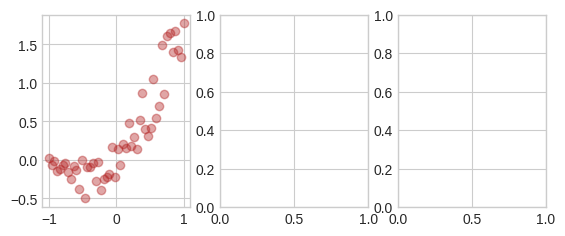

In [5]:
#| code-fold: true
#| fig-cap: Three data sets produced from the same data generating process, and the linear regression model learned for each one.
#| label: fig-three-data-example
x = torch.linspace(-1, 1, 50)

# data generating process for the targets
# we're gonna keep the same predictors (x) throughout
def generate_data(x, w0, w1, sig = 0.4):
    y = w0 + w1*x + 1*x**2 + 0.5*(x+1.2)*torch.normal(0, sig, size=x.shape)
    return y

# plot some examples
fig, ax = plt.subplots(1, 3, figsize=(6.5, 2.5))
for i in range(3):

    y      = generate_data(x, 0, 1)
    y_test = generate_data(x, 0, 1)
    ax[i].scatter(x, y_test, alpha = 0.4, color = "firebrick")
    y_hat  = predict(x, find_pars(x, y))

    ax[i].plot(x, y_hat, color='black')
    ax[i].set(xlim = (-1, 1), ylim=(-1, 2), xlabel = r"$x$")
    if i == 0:
        ax[i].set(ylabel = r"$y$")

    plt.tight_layout()

Note that, although each plot is similar, both the data set and the regression model that we learn from the data set are *slightly* different. This means that we'd get slightly different performance metrics each time.

In each repetition, we'll save the targets and the predictions: [This hidden block fits a model and tests it against a test set many times and saves the results.]{.aside}

In [ ]:
#| code-fold: true

n_reps = 1000

targets = torch.zeros(n_reps, len(x))
predictions = torch.zeros(n_reps, len(x))

for i in range(n_reps):
    y = generate_data(x, 0, 1)
    y_hat = predict(x, find_pars(x, y))
    targets[i] = generate_data(x, 0, 1)
    predictions[i] = y_hat

mean_squared_error = torch.mean((targets - predictions)**2)

print(f"The average squared error per data point is {mean_squared_error:.2f}.")

Let's look at the ensemble of models that we've produced:

In [ ]:
#| fig-cap: The 1,000 linear regression lines learned on generated data sets from the previous experiment.
#| label: fig-ensemble-of-models

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

for i in range(n_reps):
    # ax.plot(x, targets[i], color='blue', alpha=0.1)
    ax.plot([x[0], x[-1]], [predictions[i,0], predictions[i,-1]], color='black', alpha=0.01)
    ax.set(xlabel = r"$x$", ylabel = r"$y$", title = "Ensemble of Linear Regression Models")

All of these models capture the general trend, but there is some variability. Indeed, in this framework, both the value of the target $y$ at a point $x_0$ and the value of our predictor $\hat{y}$ at $x_0$ are *random variables*. So, we can use tools from probability theory to analyze the mean-squared error, which we do now.

## Bias-Variance Decomposition

With some probability in hand, let's return to our regression problem. Let's consider just a single value of the predictor $x_0$. In our repeated data generation experiment, the target at that predictor value is a random variable $Y$. Similarly, the value of our predictive model $\hat{Y}$ at $x_0$  is also a random variable.

Suppose also that we have a *predictor* for $Y$. Our predictor is *another* random variable $\hat{Y}$.[We can think of this randomness as coming from training a model on multiple realizations or subsamples of a data set. We are assuming that the predictor was trained on a *separate* training set and is therefore independent of $Y$.]{.aside} We want to know how well our predictor $\hat{Y}$ is likely to do at predicting $Y$ in a regression task. We'll therefore consider the *expected square loss* at $x_0$: [We can think of the expected square loss as a theoretical prediction about the actual value of the square loss $y - \hat{y}$ in a given data set.]{.aside}
$$
\begin{aligned}
    \mathcal{L}(x_0) = \mathbb{E}[(Y - \hat{Y})^2]\;,
\end{aligned}
$$

Here, the expectation is taken over the joint distribution of $Y$ and $\hat{Y}$. We can think of the expected square loss as a *mathematical* answer to the question we started with:

> If I generated many data sets in a similar way, trained  models on those data sets, and then averaged over each, how good a prediction would I expect to make?

We can get some insight on $\mathcal{L}(x_0)$ with a bit of algebra. Let $\mu = \mathbb{E}[Y]$ and $\hat{\mu} = \mathbb{E}[\hat{Y}]$. Then, we can write the expected square loss into three terms:

$$
\begin{aligned}
    \mathcal{L}(x_0) &= \mathbb{E}[(Y - \hat{Y})^2] \\
    &= \mathbb{E}[Y^2 - 2Y\hat{Y} + \hat{Y}^2] \\
    &= \mathbb{E}[Y^2] - 2\mathbb{E}[Y\hat{Y}] + \mathbb{E}[\hat{Y}^2] \\
    &= \mathbb{E}[Y^2] - 2\mathbb{E}[Y]\mathbb{E}[\hat{Y}] + \mathbb{E}[\hat{Y}^2] &\qquad \text{($Y$ and $\hat{Y}$ are independent)}\\
    &= \mathbb{E}[Y^2] - 2\mu\hat{\mu} + \mathbb{E}[\hat{Y}^2] &\qquad \text{(def. of $\mu$ and $\hat{\mu}$)}\\
    &= \mathbb{E}[Y^2] - \mu^2 + \mu^2 - 2\mu\hat{\mu} +  \mathbb{E}[\hat{Y}^2] - \hat{\mu}^2 + \hat{\mu}^2 \\
    &= \mathrm{var}(Y) + \mathrm{var}(\hat{Y}) + \mu^2 - 2\mu\hat{\mu} + \hat{\mu}^2 &\qquad \text{Variance formula}\\
    &= \underbrace{\mathrm{var}(Y)}_{\text{noise}} + \underbrace{\mathrm{var}(\hat{Y})}_{\text{variance}} + \underbrace{(\mu - \hat{\mu})^2}_{\text{bias}} \\
\end{aligned}
$$

Let's take a moment with each of these terms.

- The first term, $\mathrm{var}(Y)$, is the *intrinsic noise* in the data at $x_0$. This is the amount of variability in the target $Y$. **There is nothing we can do about the noise**: it is a property of a data set and out of our control. It is not possible to construct a predictor of $Y$ that has a lower expected square loss than the noise.
- The second term, $\mathrm{var}(\hat{Y})$, is the *variance* of our predictor at $x_0$. This is the extent to which our model is flexibly responsive to the data. Very flexible models typically have high variance, while simple models (like the linear regression model we're using here) tend to have low variance.
- The final term, $(\mu - \hat{\mu})^2$, is the *bias* of our predictor at $x_0$. This is a measure of the difference between the expected value of the target and the expected value of the predictor. So, what we're measuring here is the tendency of our predictive model to be *systematically wrong* relative to the target. High-bias models "don't look like they fit the data very well." We can generally reduce the bias by choosing a more flexible model class.

## Numerical Example

Let's compute each of these terms from the linear regression experiment that we did earlier. Since our analysis above was at a specific data point, we are going to compute values at each data point and then compare. [Passing `dim = 0` to each of these method calls ensures that the results for each data point are pooled separately.]{.aside}

In [ ]:
noise    = targets.var(dim = 0, correction = 0)
variance = predictions.var(dim = 0, correction = 0)
bias     = (targets.mean(dim = 0) - predictions.mean(dim = 0))**2
mse      = ((targets - predictions)**2).mean(dim = 0)

Now we can get a quantitative description of the sources of error in our model by plotting each one and the total mean-squared error. We'll show this alongside an example data set and predictor for comparison:

In [ ]:
#| code-fold: true
#| fig-cap: Illustration of the bias-variance decomposition in linear regression on our sample data generating process. (Left). Sample data set and model. (Right). Bias-variance decomposition.
#| label: fig-bias-variance-decomposition

fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

y = generate_data(x, 0, 1)
y_test = generate_data(x, 0, 1)
ax[0].scatter(x, y_test, alpha = 0.5, color = "firebrick")
y_hat = predict(x, find_pars(x, y))

ax[0].plot(x, y_hat, color='black')
ax[0].set(xlabel = r"$x$", ylabel = r"$y$", title = "Example data set and predictor")

ax[1].plot(x, noise, label = "data noise", linestyle = "--")
ax[1].plot(x, variance, label = "model variance", linestyle = "--")
ax[1].plot(x, bias, label = "model bias", linestyle = "--")
ax[1].plot(x, mse, label = "mse", color = "black")

ax[1].set(xlabel = r"$x$", ylabel = "Error", title =
"Bias-Variance Decomposition")

plt.legend()
plt.tight_layout()

In this experiment, the noise and bias are the two primary contributors to the mean-squared error, with the model variance being quite low. The data generating process is deliberately constructed so that the data is noisier in certain regions, and so that the model bias also varies across regions.

In this particular case, we could likely achieve a better result by choosing a more flexible model with nonlinear features, as we'll try soon.

## Bias-Variance Tradeoff: The Classical View

If you were paying careful attention above, you may have noticed that increasing the model flexibility is a way to *decrease* bias but *increase* variance. This is the *bias-variance tradeoff*: often, reducing one of these two sources of error comes at the cost of increasing the other.

To illustrate the standard problem here, let's run an experiment in which we train a series of polynomial regression models with increasing flexibility on a sinusoidal data set. Here are a few examples of the models we'll train, with different orders: [This hidden code block defines a data generator for a sinusoidal data set and then shows two examples of fitting polynomial regression models.]{.aside}

In [ ]:
#| code-fold: true
#| fig-cap: Illustration of fitting polynomial regression models of different orders to a sinusoidal data set.
#| label: fig-polynomial-regression
def generate_sin_data(x, sig = 0.4):
    y = torch.sin(1*np.pi*x) + torch.normal(0, sig, size=x.shape)
    return y

fig, ax = plt.subplots(1, 2, figsize=(7, 3))

order = 1

y      = generate_sin_data(x)
y_test = generate_sin_data(x)

w     = find_pars(x, y, order)
y_hat = predict(x, w, order)

ax[0].scatter(x, y_test,  label = "data", color = "firebrick", alpha = 0.5)
ax[0].plot(x, y_hat, color='black', label = "model")
ax[0].set(title = f"Order {order}: Low Variance, High Bias", xlabel = r"$x$", ylabel = r"$y$")


order = 20
w     = find_pars(x, y, order)
y_hat = predict(x, w, order)

ax[1].scatter(x, y_test,  label = "data", color = "firebrick", alpha = 0.5)
ax[1].plot(x, y_hat, color='black', label = "model")
ax[1].set(title = f"Order {order}: Low Variance, High Bias", xlabel = r"$x$", ylabel = r"$y$")

plt.tight_layout()

Now let's estimate the terms in the bias-variance decomposition as we vary the model order:

In [ ]:
#| fig-cap: Illustration of the bias-variance tradeoff in polynomial regression on the sinusoidal data generator.
#| label: fig-bias-variance-tradeoff
#| code-fold: true

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

n_reps = 100
max_order = 10

variances = torch.zeros(max_order)
biases    = torch.zeros(max_order)
mses      = torch.zeros(max_order)
noises    = torch.zeros(max_order)

for order in range(0, max_order):

    targets = torch.zeros(n_reps, len(x))
    predictions = torch.zeros(n_reps, len(x))

    for i in range(n_reps):
        y = generate_sin_data(x)
        w = find_pars(x, y, order)
        y_hat = predict(x, w, order )
        targets[i] = generate_sin_data(x)
        predictions[i] = y_hat

    # noise of data
    noises[order] = targets.var(dim = 0, correction = 0).mean()

    # variance of predictions
    variances[order] = predictions.var(dim = 0, correction = 0).mean()

    # bias of predictions:
    biases[order] = ((targets.mean(dim = 0) - predictions.mean(dim = 0))**2).mean()

    mses[order] = ((targets - predictions)**2).mean()

ax.plot(torch.arange(max_order), mses, label = "mse", color = "black")
ax.plot(torch.arange(max_order), variances, label = "model variance", linestyle = "--")
ax.plot(torch.arange(max_order), noises, label = "data noise", linestyle = "--")
ax.plot(torch.arange(max_order), biases, label = "model bias", linestyle = "--")
ax.scatter(torch.arange(max_order), mses, color = "black")
ax.scatter(torch.arange(max_order), variances)
ax.scatter(torch.arange(max_order), noises)
ax.scatter(torch.arange(max_order), biases)



ax.set(xlabel = "Model Order", ylabel = "Error", title = "Illustration: Bias-Variance Tradeoff", xlim = (-0.5, None))

plt.legend()

When the model order is small, the bias is very high -- the model is underfit. As the model order increases, the bias shrinks rapidly, but the model variance begins to climb. Eventually, at order roughly 3, we reach a point at which the model is optimally flexible: increasing the model order will increase the model flexibility, and therefore variance, without enough of a benefit for reducing the bias.

It is also possible to observe the same bias-variance tradeoff by varying other hyperparameters that control the model flexibility, such as the regularization parameter $\lambda$ in ridge regression.

## Limitations of the Classical View

The visualization in @fig-bias-variance-tradeoff represents the *classical* view of the bias-variance tradeoff, and expresses the conventional wisdom of machine learning in roughly the era up until 2015 or so:

> Adding more complexity to a model eventually becomes a bad idea.

The phenomenon in view here is sometimes called "single descent": the MSE descends (once) as the model complexity increases, before increasing again past the optimal point.

However, this classical view leaves us with a mystery: if there is such a thing as too much model flexibility, then why is it that *extremely flexible* deep learning models with billions of parameters can perform well on data? In fact, in modern experiments we often observe a *double descent* phenomenon: the test error decreases with the model complexity, then increases, and then begins to decrease *again*:

![Figure from @rocks2022memorizing via [Wikipedia](https://en.wikipedia.org/wiki/Double_descent#/media/File:Double_descent_in_a_two-layer_neural_network_(Figure_3a_from_Rocks_et_al._2022).png).](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d7/Double_descent_in_a_two-layer_neural_network_%28Figure_3a_from_Rocks_et_al._2022%29.png/1600px-Double_descent_in_a_two-layer_neural_network_%28Figure_3a_from_Rocks_et_al._2022%29.png?20230604175729)

The capability of highly-flexible models to avoid overfitting and achieve strong performance is a central insight of the deep learning revolution and an area of active research in the theory of machine learning.



## Reference: Random Variables, Expectation, and Variance

In order to state the bias-variance tradeoff, we need to recall a few definitions from probability.

*We provide the rapid review of definitions below for* ***discrete*** *sample spaces and random variables. The theory is not substantially different for continuous random variables, but the notation is more complicated.*

::: {.callout-note}
::: {#def-sample-space}

## Sample Space and Events

A *sample space* $S$ is a set of possible *outcomes*. An *event* $A$ is a subset of the sample space $S$. To each event $A \subseteq S$ we can associate a *probability* $\mathbb{P}(A)$ of the event occurring.

:::
:::

::: {.callout-note}
::: {#def-random-variables}

## Random Variables and Probability Mass Functions

A *random variable* $X$ is a function that assigns a real number to each outcome in a sample space $S$. The *event* $X = x$ is the set of outcomes $\{s \in S \;:\; X(s) = x\}$. The probability of the event $X = x$ is $\mathbb{P}(X = x)$. We often denote this probability as $p_X(x)$. This function $p_X$ is called the *probability mass function* of the random variable $X$. We also often colloquially call it the "distribution" of $X$.

:::
:::

::: {.callout-note}
::: {#def-jointly-random}

## Jointly Random Variables, Marginals

Two random variables $X$ and $Y$ defined on the sample sample space $S$ have a *joint distribution* $p_{X,Y}(x, y) = \mathbb{P}(X = x \cap Y = y)$. The *marginal distributions* of $X$ and $Y$ are

$p_X(x) =  \sum_y p_{X,Y}(x, y)$ and $p_Y(y) = \sum_x p_{X,Y}(x, y)$.

:::
:::

::: {.callout-note}
::: {#def-independence}

## Independence

Random variables $X$ and $Y$ are *independent* if it is the case that $p_{X,Y}(x,y) = p_X(x)p_Y(y)$ for all $x$ and $y$.

:::
:::

::: {.callout-note}
::: {#def-expectation}

## Expectation

The *expectation* of a random variable $X$ is

$$
\begin{aligned}
    \mathbb{E}[X] = \sum_x x p_X(x).
\end{aligned}
$$

The expectation of a function of two jointly distributed random variables is

$$
\begin{aligned}
    \mathbb{E}[f(X,Y)] = \sum_{x,y} f(x,y) p_{X,Y}(x,y).
\end{aligned}
$$

:::
:::

::: {.callout-note}
::: {#thm-expectation-properties}

## Properties of the Expectation

1. **Linearity**: If $X$ and $Y$ are random variables, and $a$ and $b$ are real numbers, then $\mathbb{E}[aX + bY] = a\mathbb{E}[X] + b\mathbb{E}[Y]$.
2. **Independence**: If $X$ and $Y$ are independent random variables, then $\mathbb{E}[XY] = \mathbb{E}[X]\mathbb{E}[Y]$.

:::
:::


::: {.callout-note}
::: {#def-variance}

## Variance of a Random Variable

By definition, the variance of a random variable $X$ is $\mathrm{var}(X) = \mathbb{E}[X^2] - (\mathbb{E}[X])^2$.

A useful alternative formula for the variance is $\mathrm{var}(X) = \mathbb{E}[(X - \mathbb{E}[X])^2]$.

:::
:::

## References